## Try to do a clustering with the selected features. 

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## DBScan

In [88]:
data_folder_path = "../data"  # Update this path accordingly
df = pd.DataFrame()

file_list = [file for file in os.listdir(data_folder_path) if not file.startswith('60')]

for file_name in file_list:
    root_file_path = os.path.join(data_folder_path, file_name)
    csv_df = pd.read_csv(root_file_path)
    csv_df['memory_usage'] = file_name.split('.')[0]
    df = pd.concat([df, csv_df])

#### Feature engineering

In [89]:
df["time"] = df.groupby("memory_usage").cumcount()
df["fan_speed_diff"] = df["fan_tegrapwm_speed"] - df.groupby("memory_usage")["fan_tegrapwm_speed"].transform("first")
df["GPU_temp"] = df["temperature_GPU_temp"] - df.groupby("memory_usage")["temperature_GPU_temp"].transform("first")

df_numeric = df.select_dtypes(include="number")
df_numeric = df_numeric.drop(columns=df_numeric.filter(like="process").columns)
df_numeric = df_numeric.drop(columns=[col for col in df_numeric.columns if "status" in col or 'state' in col or 'min' in col or 'max' in col or 'nice' in col or 'EMC' in col or 'IRAM' in col or 'rpm' in col or 'crit' in col or 'temperature_GPU_temp' in col or 'fan_tegrapwm_speed' in col])

In [90]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [91]:
df_numeric.isna().sum()

Unnamed: 0                         0
cpu_0_freq_cur                     0
cpu_0_idle                         0
cpu_0_info_freq_cur                0
cpu_0_system                       0
cpu_0_user                         0
cpu_1_freq_cur                     0
cpu_1_idle                         0
cpu_1_info_freq_cur                0
cpu_1_system                       0
cpu_1_user                         0
cpu_2_freq_cur                     0
cpu_2_idle                         0
cpu_2_info_freq_cur                0
cpu_2_system                       0
cpu_2_user                         0
cpu_3_freq_cur                     0
cpu_3_idle                         0
cpu_3_info_freq_cur                0
cpu_3_system                       0
cpu_3_user                         0
engines_SE_cur                     0
gpu_freq_cur                       0
mem_RAM_buffers                    0
mem_RAM_cached                     0
mem_RAM_free                       0
mem_RAM_lfb                        0
m

In [92]:
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)
df_scaled = df_scaled.drop(columns=['power_rail', 'uptime', 'Unnamed: 0'])

In [94]:
# Applicazione di DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=15)
df["cluster"] = dbscan.fit_predict(df_scaled)

In [95]:
df['cluster'].unique()

array([-1,  0,  1,  4,  2,  3,  5,  7,  6,  8,  9, 11, 10, 12, 13, 14, 15,
       16, 17, 20, 18, 19, 21, 22, 25, 23, 24, 26, 27, 28, 29])

<Axes: title={'center': 'DBSCAN - Outlier Detection'}, xlabel='fan_speed_diff', ylabel='GPU_temp'>

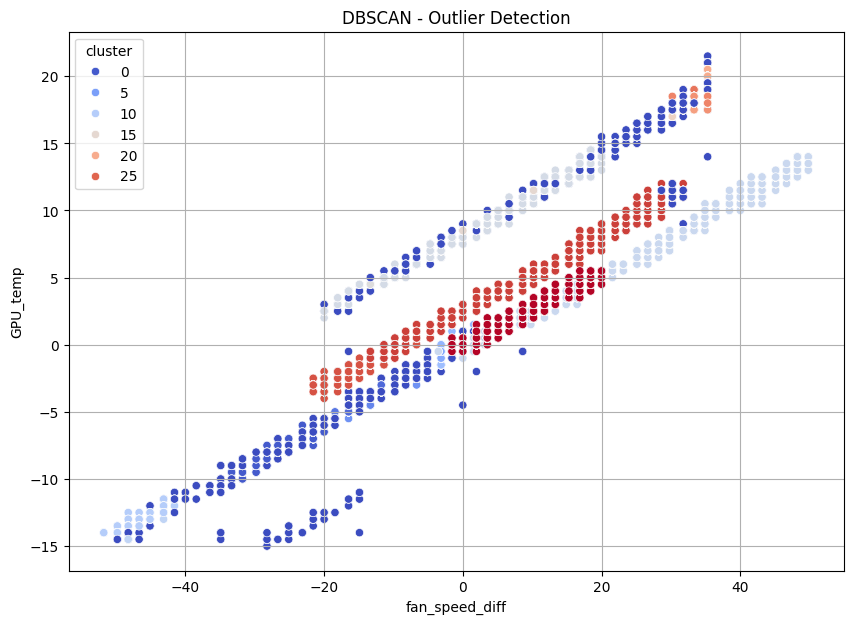

In [96]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.set_title("DBSCAN - Outlier Detection")
ax.grid()
sns.scatterplot(x="fan_speed_diff", y="GPU_temp", hue=df["cluster"], palette="coolwarm", data=df, ax=ax)

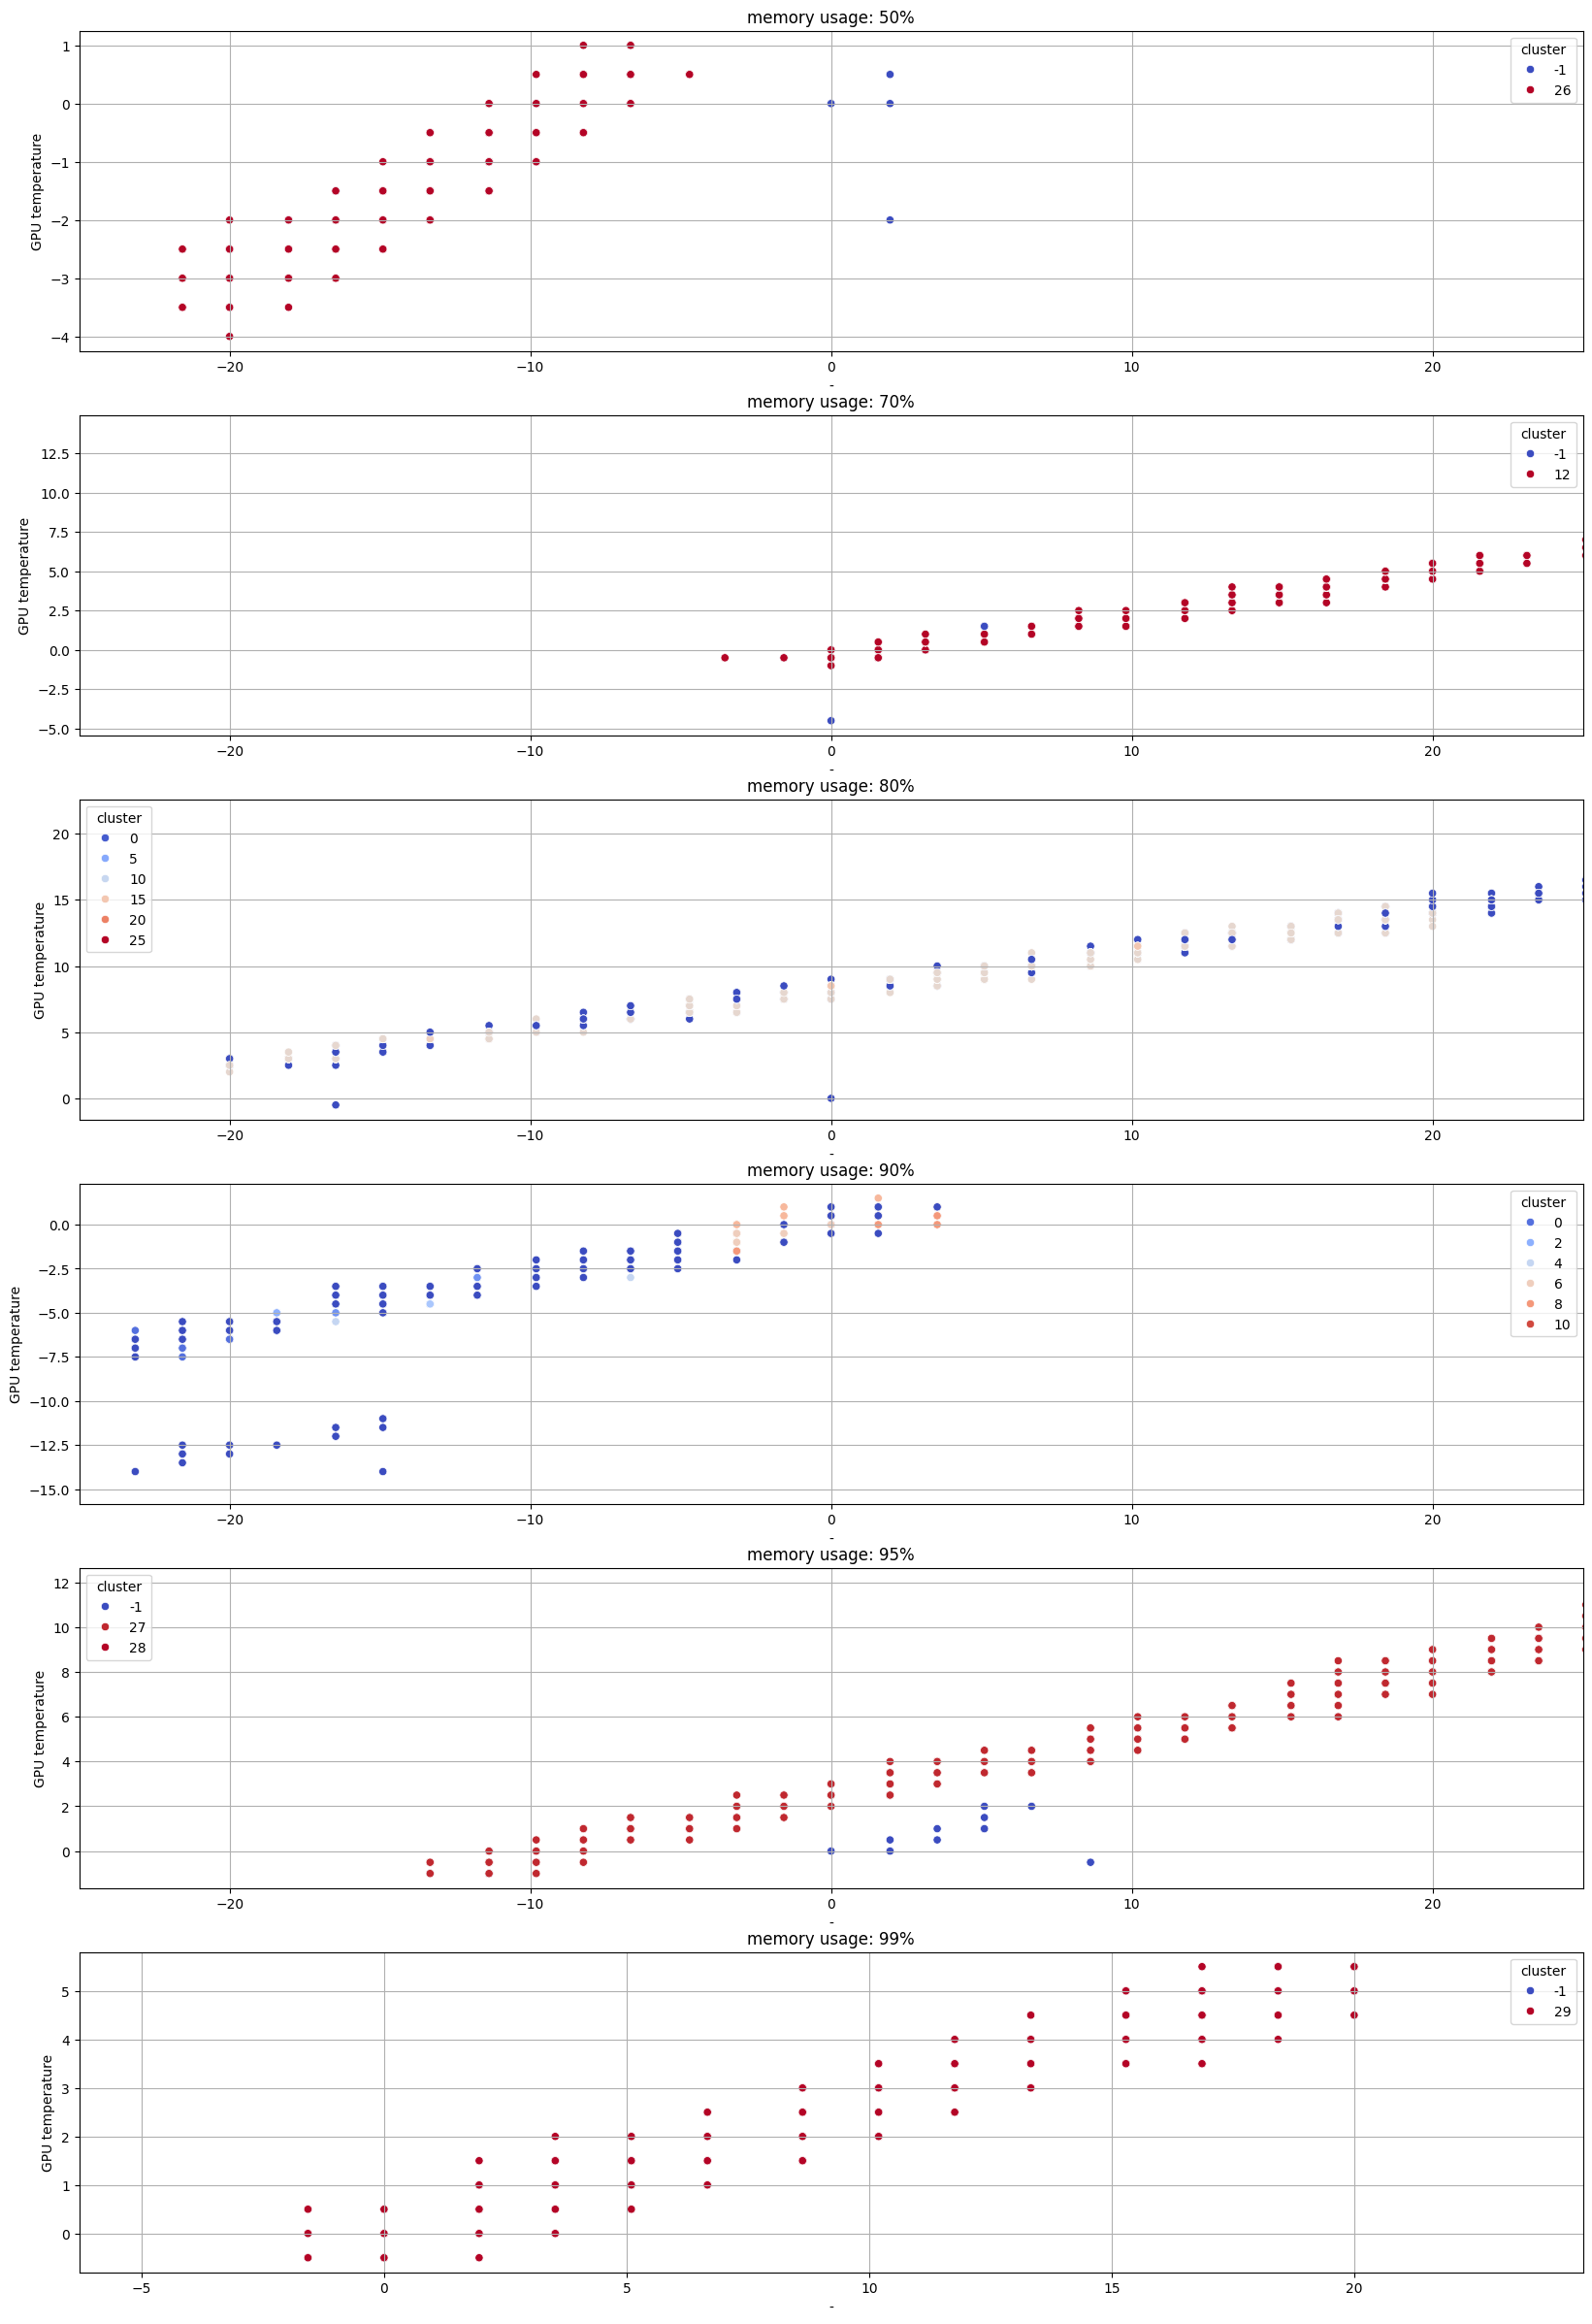

In [97]:
fig, ax = plt.subplots(6,1,figsize=(20,30))
for mem_us_idx in range(len(df['memory_usage'].unique())):
    ordered_labels = df['memory_usage'].unique()
    ordered_labels.sort()
    filtered_df = df[df['memory_usage']==ordered_labels[mem_us_idx]]
    ax[mem_us_idx].set_title(f"memory usage: {ordered_labels[mem_us_idx]}")
    ax[mem_us_idx].set_xlabel('-')
    ax[mem_us_idx].grid()
    ax[mem_us_idx].set_ylabel('GPU temperature')
    ax[mem_us_idx].set_xlim((-50, 40))
    ax[mem_us_idx].set_xlim((-25, 25))
    sns.scatterplot(x="fan_speed_diff", y="GPU_temp", hue=filtered_df["cluster"], palette="coolwarm", data=filtered_df, ax=ax[mem_us_idx])
    plt.axis('equal')
    

In [98]:
df_numeric.columns

Index(['Unnamed: 0', 'cpu_0_freq_cur', 'cpu_0_idle', 'cpu_0_info_freq_cur',
       'cpu_0_system', 'cpu_0_user', 'cpu_1_freq_cur', 'cpu_1_idle',
       'cpu_1_info_freq_cur', 'cpu_1_system', 'cpu_1_user', 'cpu_2_freq_cur',
       'cpu_2_idle', 'cpu_2_info_freq_cur', 'cpu_2_system', 'cpu_2_user',
       'cpu_3_freq_cur', 'cpu_3_idle', 'cpu_3_info_freq_cur', 'cpu_3_system',
       'cpu_3_user', 'engines_SE_cur', 'gpu_freq_cur', 'mem_RAM_buffers',
       'mem_RAM_cached', 'mem_RAM_free', 'mem_RAM_lfb', 'mem_RAM_shared',
       'mem_RAM_tot', 'mem_RAM_used', 'mem_SWAP_cached', 'mem_SWAP_tot',
       'mem_SWAP_used', 'power_rail', 'power_rail_POM_5V_CPU_avg',
       'power_rail_POM_5V_CPU_curr', 'power_rail_POM_5V_CPU_power',
       'power_rail_POM_5V_CPU_volt', 'power_rail_POM_5V_CPU_warn',
       'power_rail_POM_5V_GPU_avg', 'power_rail_POM_5V_GPU_curr',
       'power_rail_POM_5V_GPU_power', 'power_rail_POM_5V_GPU_volt',
       'power_rail_POM_5V_GPU_warn', 'temperature_AO_temp',
       '

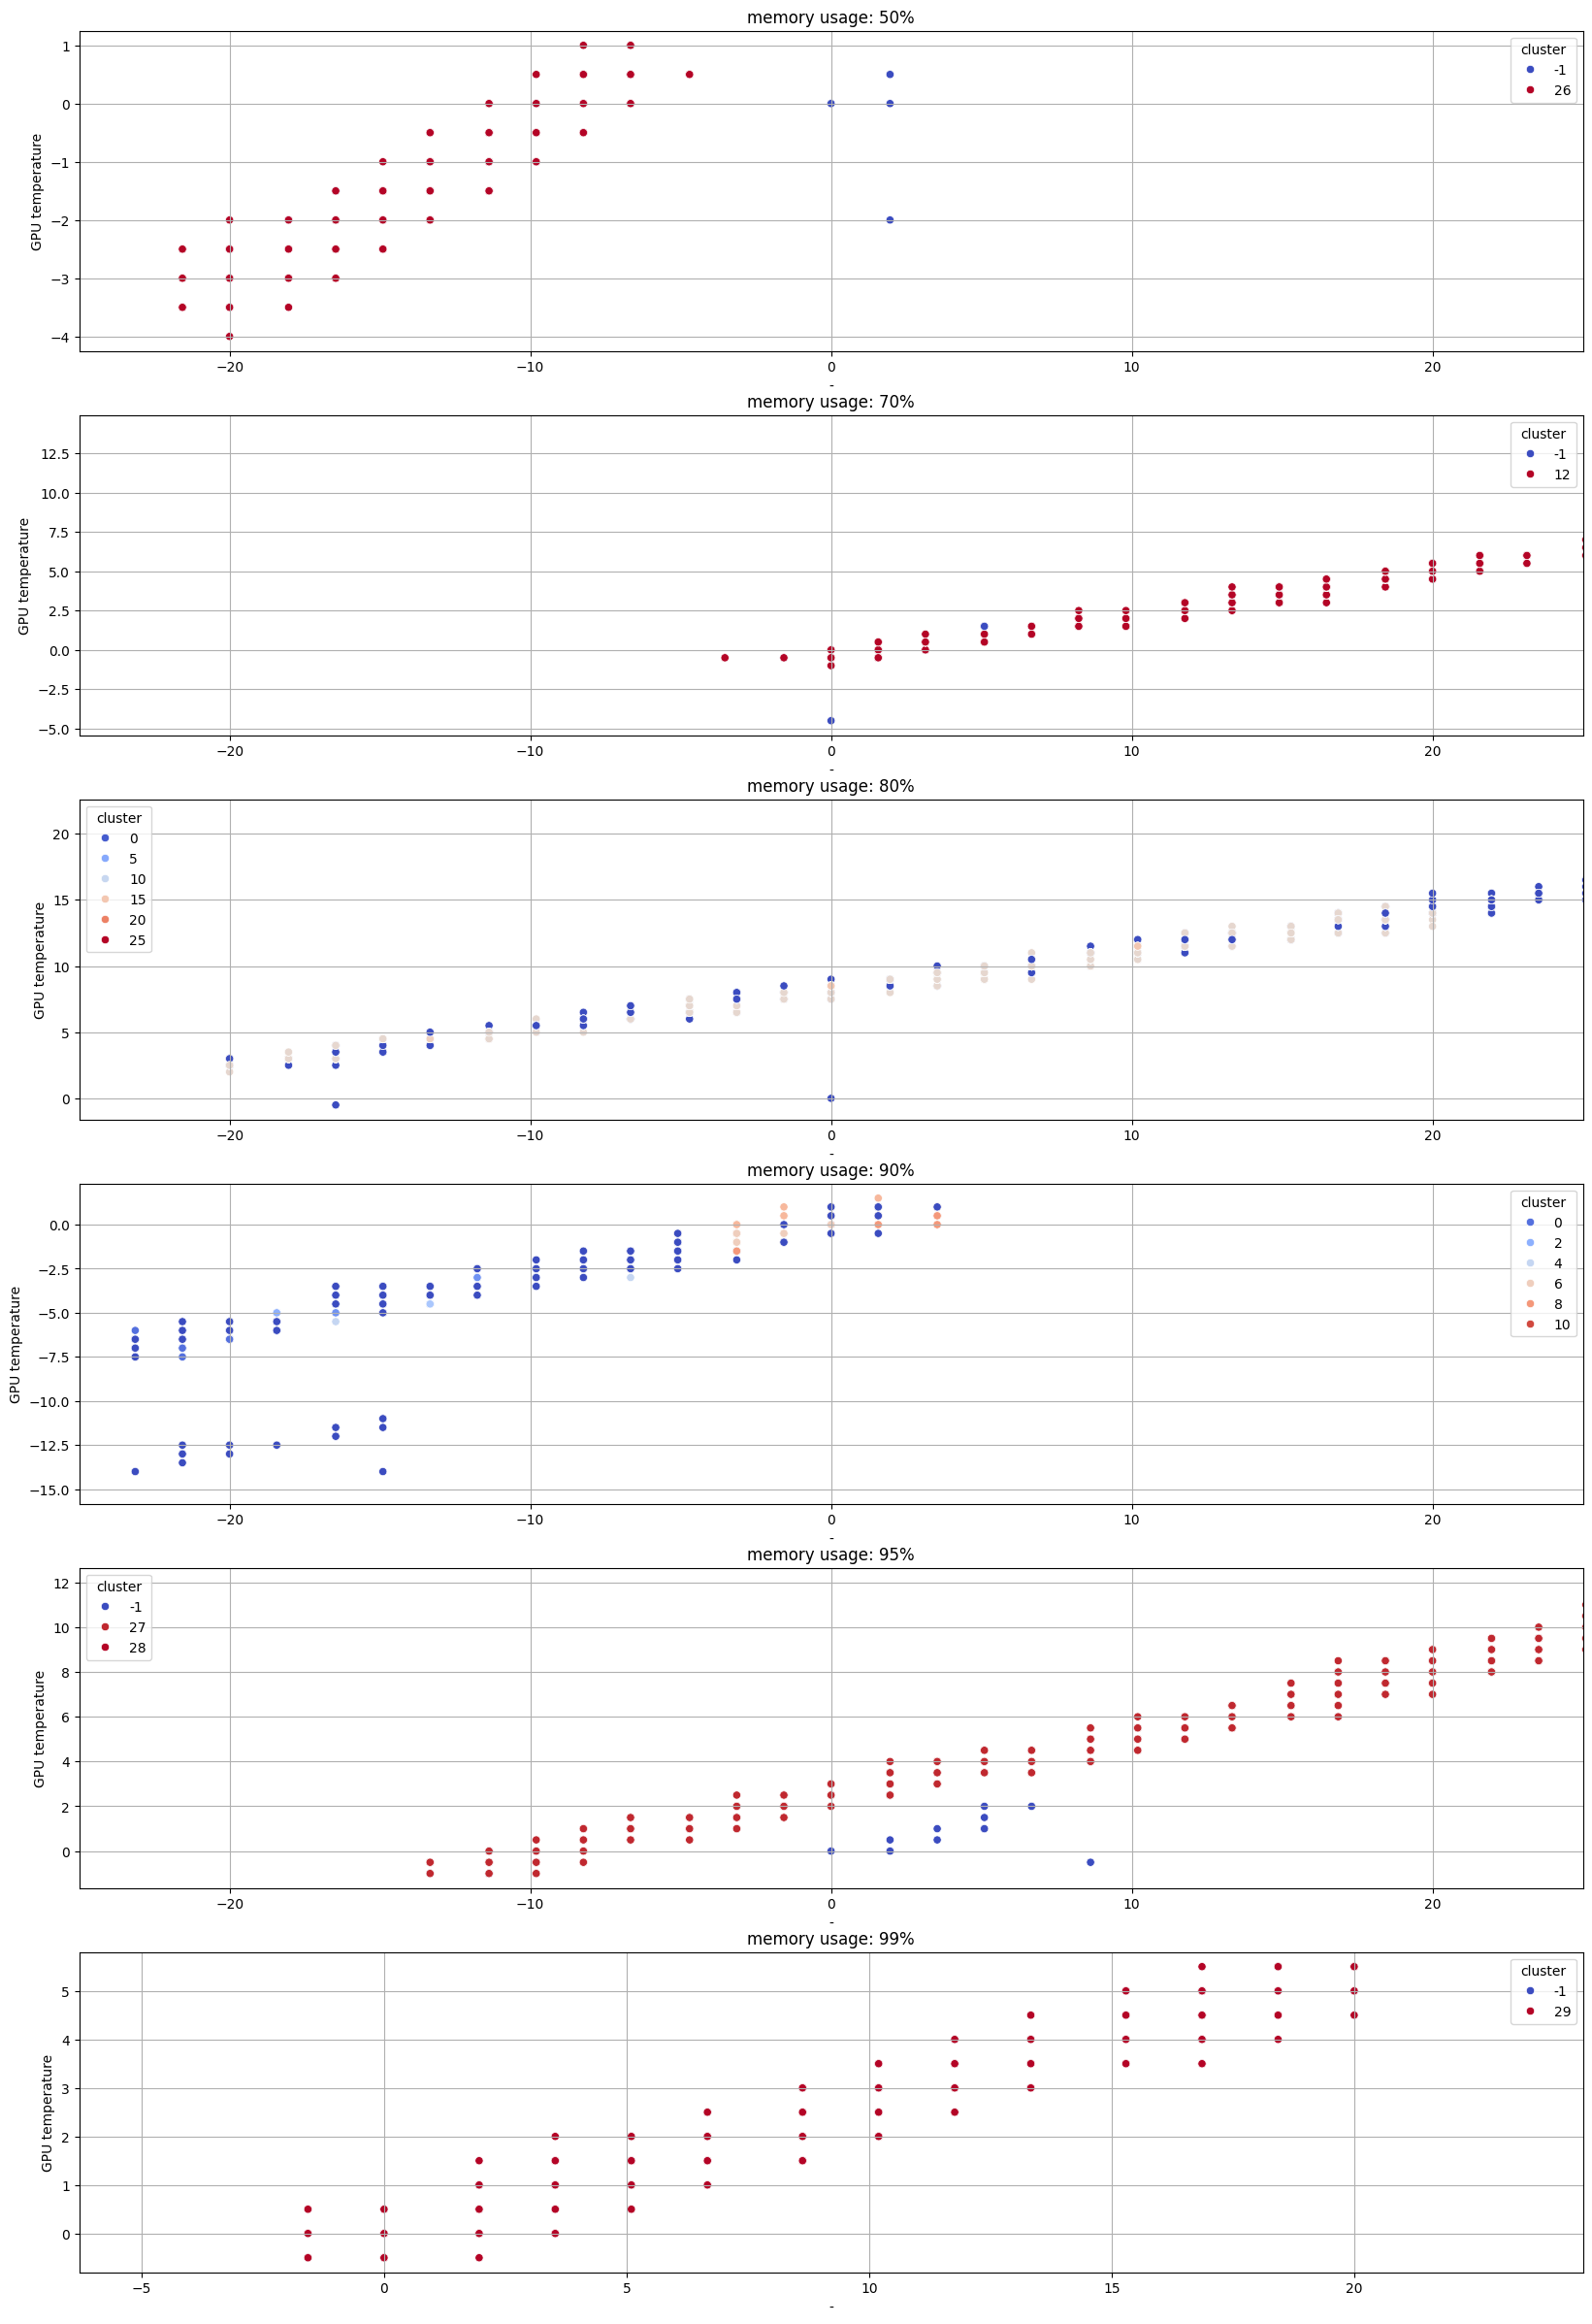

In [99]:
fig, ax = plt.subplots(6,1,figsize=(20,30))
for mem_us_idx in range(len(df['memory_usage'].unique())):
    ordered_labels = df['memory_usage'].unique()
    ordered_labels.sort()
    filtered_df = df[df['memory_usage']==ordered_labels[mem_us_idx]]
    ax[mem_us_idx].set_title(f"memory usage: {ordered_labels[mem_us_idx]}")
    ax[mem_us_idx].set_xlabel('-')
    ax[mem_us_idx].grid()
    ax[mem_us_idx].set_ylabel('GPU temperature')
    ax[mem_us_idx].set_xlim((-50, 40))
    ax[mem_us_idx].set_xlim((-25, 25))
    sns.scatterplot(x="fan_speed_diff", y="GPU_temp", hue=filtered_df["cluster"], palette="coolwarm", data=filtered_df, ax=ax[mem_us_idx])
    plt.axis('equal')
    

In [137]:
df_numeric.columns

Index(['Unnamed: 0', 'cpu_0_freq_cur', 'cpu_0_idle', 'cpu_0_info_freq_cur',
       'cpu_0_system', 'cpu_0_user', 'cpu_1_freq_cur', 'cpu_1_idle',
       'cpu_1_info_freq_cur', 'cpu_1_system', 'cpu_1_user', 'cpu_2_freq_cur',
       'cpu_2_idle', 'cpu_2_info_freq_cur', 'cpu_2_system', 'cpu_2_user',
       'cpu_3_freq_cur', 'cpu_3_idle', 'cpu_3_info_freq_cur', 'cpu_3_system',
       'cpu_3_user', 'engines_SE_cur', 'gpu_freq_cur', 'mem_RAM_buffers',
       'mem_RAM_cached', 'mem_RAM_free', 'mem_RAM_lfb', 'mem_RAM_shared',
       'mem_RAM_tot', 'mem_RAM_used', 'mem_SWAP_cached', 'mem_SWAP_tot',
       'mem_SWAP_used', 'power_rail', 'power_rail_POM_5V_CPU_avg',
       'power_rail_POM_5V_CPU_curr', 'power_rail_POM_5V_CPU_power',
       'power_rail_POM_5V_CPU_volt', 'power_rail_POM_5V_CPU_warn',
       'power_rail_POM_5V_GPU_avg', 'power_rail_POM_5V_GPU_curr',
       'power_rail_POM_5V_GPU_power', 'power_rail_POM_5V_GPU_volt',
       'power_rail_POM_5V_GPU_warn', 'temperature_AO_temp',
       '

The column 'power_rail_POM_5V_GPU_avg' is numeric.


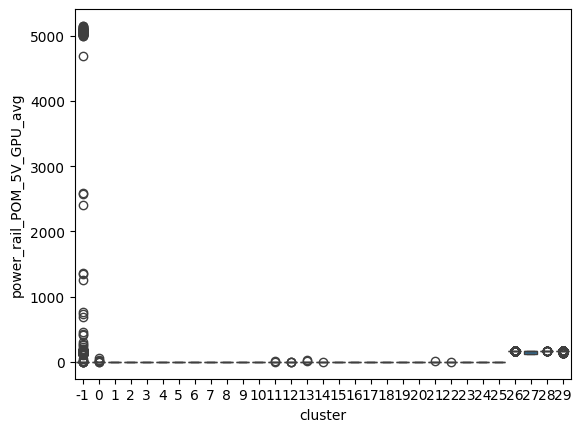

The column 'power_rail_POM_5V_GPU_volt' is numeric.


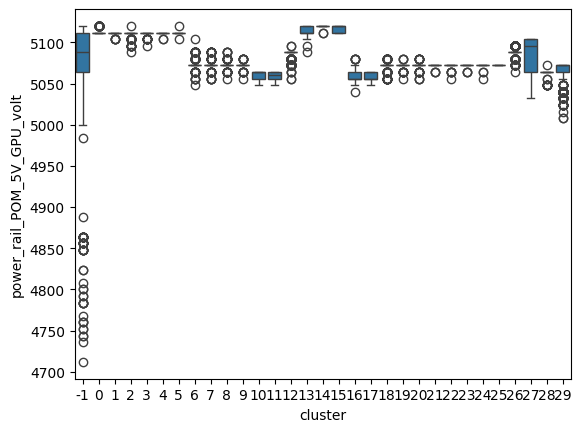

The column 'temperature_GPU_temp' is numeric.


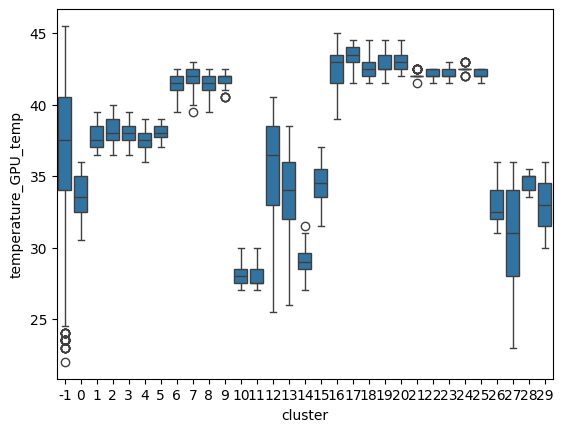

The column 'gpu_freq_cur' is numeric.


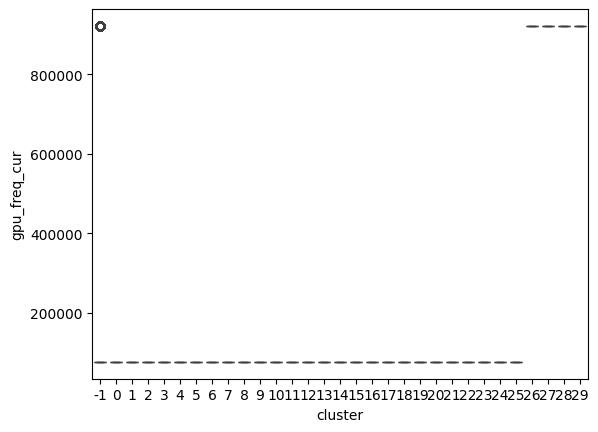

In [138]:

for feature in ['power_rail_POM_5V_GPU_avg', 'power_rail_POM_5V_GPU_volt', 'temperature_GPU_temp', 'fan_tegrapwm_speed', 'gpu_freq_cur']:
    try:
        if 'gpu' in feature.lower():
            pd.to_numeric(df[feature])
            print(f"The column '{feature}' is numeric.")
            sns.boxplot(x=df['cluster'], y=df[feature])
            plt.show()
    except ValueError:
        print(f"The column '{feature}' is not entirely numeric.")



In [119]:
from sklearn.ensemble import IsolationForest

# Creazione del modello Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.1)
model.fit(df_scaled)

# Predizione degli outlier
outliers = model.predict(df_scaled)

# Visualizzazione dei risultati
# df = pd.DataFrame(df_numeric, columns=['Feature 1', 'Feature 2'])
df_scaled['outlier'] = outliers
df_scaled['outlier']

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
17179    1
17180    1
17181    1
17182    1
17183    1
Name: outlier, Length: 17184, dtype: int64

<Axes: xlabel='gpu_freq_cur', ylabel='Density'>

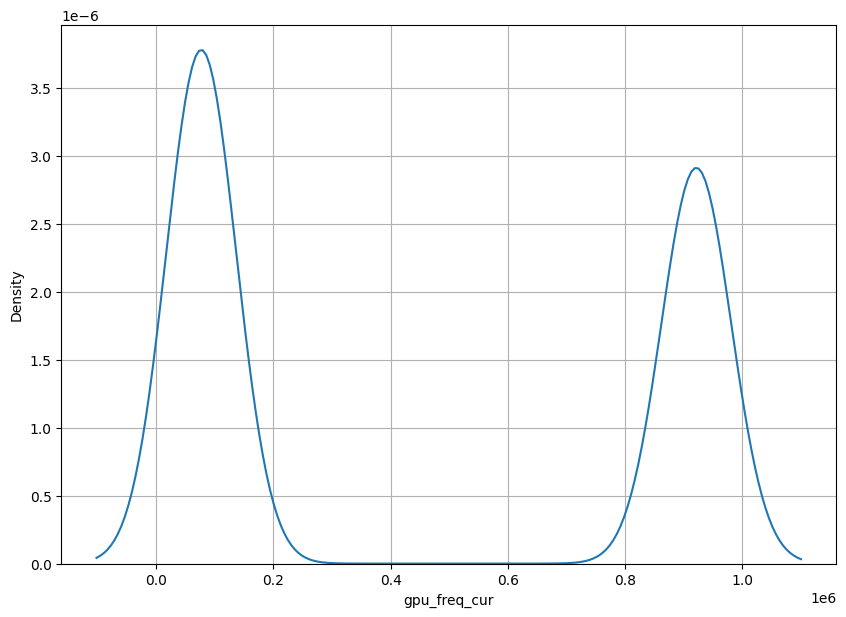

In [140]:
# df['gpu_freq_cur']
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.grid()
sns.kdeplot(data=df, x='gpu_freq_cur')

In [120]:
len(df_scaled.columns)

50

In [123]:
from sklearn.inspection import permutation_importance

# Permutazione delle feature per misurare l'importanza
result = permutation_importance(model, df_scaled, outliers, n_repeats=10, random_state=42, scoring='accuracy')

# Visualizzazione dei punteggi di importanza
importances = pd.DataFrame(result.importances_mean, columns=['Importance'])
importances['feature_name'] = df_scaled.columns

In [132]:
ax.get_xticklabels()

[Text(0, 0, '0.0'),
 Text(1, 0, '0.2'),
 Text(2, 0, '0.4'),
 Text(3, 0, '0.6'),
 Text(4, 0, '0.8'),
 Text(5, 0, '1.0'),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, '')]

/tmp/ipykernel_36445/1105181074.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'cpu_0_info_freq_cur'),
 Text(1, 0, 'cpu_1_freq_cur'),
 Text(2, 0, 'cpu_1_idle'),
 Text(3, 0, 'cpu_1_user'),
 Text(4, 0, 'cpu_2_freq_cur'),
 Text(5, 0, 'cpu_2_info_freq_cur'),
 Text(6, 0, 'cpu_3_idle'),
 Text(7, 0, 'cpu_3_user'),
 Text(8, 0, 'mem_RAM_buffers'),
 Text(9, 0, 'mem_RAM_used'),
 Text(10, 0, 'mem_SWAP_cached'),
 Text(11, 0, 'power_rail_POM_5V_CPU_avg'),
 Text(12, 0, 'power_rail_POM_5V_CPU_curr'),
 Text(13, 0, 'power_rail_POM_5V_CPU_volt'),
 Text(14, 0, 'power_rail_POM_5V_GPU_volt'),
 Text(15, 0, 'time'),
 Text(16, 0, 'outlier')]

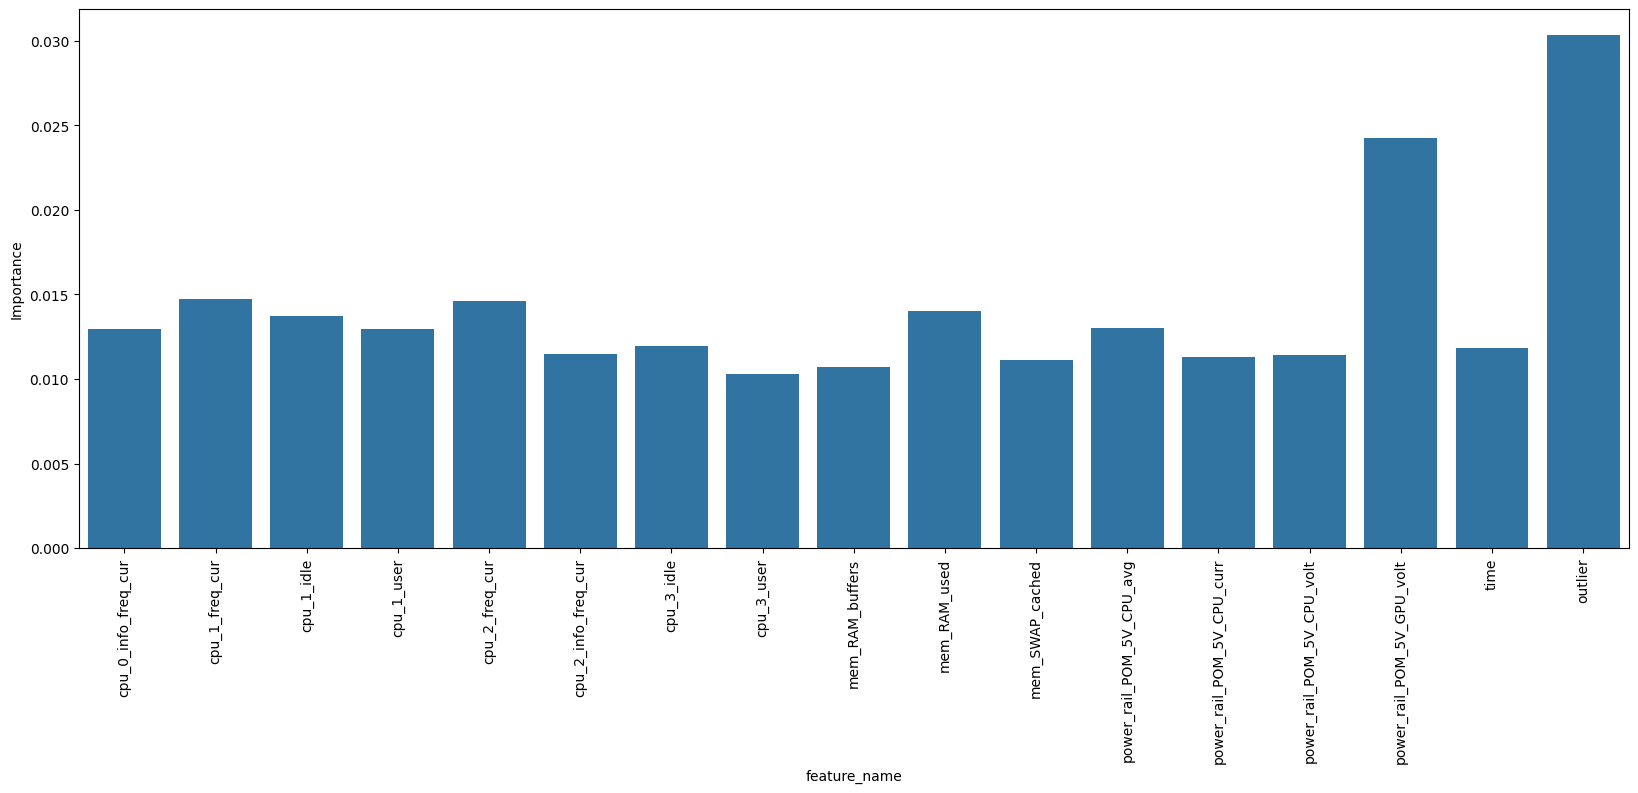

In [134]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data=importances[importances['Importance']>0.010], x='feature_name', y='Importance', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)